<a href="https://colab.research.google.com/github/Yassiaap/DLAGA/blob/code/gene_expression_classification_dataset2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# connect google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Gene

/content/drive/MyDrive/Gene


## import

In [ ]:
# Import all the libraries that we shall be using
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
import random
random.seed(42)

from google.colab import files



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, svm, model_selection, tree, ensemble, neighbors, preprocessing, base, metrics
#import category_encoders
import imblearn

# preprocessing

Let's start by taking a look at our target, the ALL/AML label.

In [ ]:
# Import labels (for the whole dataset, both training and testing)
df = pd.read_csv('DLBCL.csv')
print(df.shape)
df.head()

(77, 7071)


,A28102,AB000114_at,AB000115_at,AB000220_at,AB000409_at,AB000449_at,AB000450_at,AB000460_at,AB000462_at,AB000464_at,...,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at,class
0,-1,-45,176,97,-57,233,265,945,56,819,...,1036,-161,1523,-72,897,366,3,76,-28,DLBCL
1,25,-17,531,353,122,155,209,1688,42,639,...,4254,-75,6056,-68,737,81,-4,41,-45,DLBCL
2,73,91,257,80,614,507,760,2252,196,863,...,1934,-129,2901,-9,946,450,38,164,-62,DLBCL
3,267,41,202,138,198,355,245,1469,170,384,...,2469,93,2465,-119,339,321,-63,73,-13,DLBCL
4,16,24,187,39,145,254,571,930,-11,439,...,608,-39,1667,-87,721,213,15,155,-26,DLBCL


In the combined training and testing sets there are 72 patients, each of whom are labelled either "ALL" or "AML" depending on the type of leukemia they have. Here's the breakdown:

In [ ]:
df['class'].value_counts()

0    58
1    19
Name: class, dtype: int64

We actually need our labels to be numeric, so let's just do that now.

In [ ]:
# Recode label to numeric
df = df.replace({'DLBCL':0,'FL':1})
labels = ['DLBCL', 'FL'] # for plotting convenience later on

In [ ]:
X = df.drop('class', axis = 1).values
y = df['class'].values

print(X.shape, y.shape)

(77, 7070) (77,)


In [ ]:
# Splitting the data into testing and training data (Stratified Splitting)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

print(X_train.shape, X_test.shape)

(61, 7070) (16, 7070)


In [ ]:
ychecktrain=y_train
ychecktest=y_test
Xchechtrain=X_train
Xchechtest=X_test

# normalization
Clearly there is some variation in the scales across the different features. Many machine learning models work much better with data that's on the same scale, so let's create a scaled version of the dataset.

In [ ]:

# Convert from integer to float

X_train_fl = X_train.astype(float)
X_test_fl = X_test.astype(float)



# Apply the same scaling to both datasets
from sklearn.preprocessing import RobustScaler
transformer = RobustScaler().fit(X_train_fl)
X_train=transformer.transform(X_train_fl)
transformer = RobustScaler().fit(X_test_fl)
X_test=transformer.transform(X_test_fl)

#scaler = StandardScaler()
##X_train = scaler.fit_transform(X_train)

#X_test = scaler.transform(X_test) # note that we transform rather than fit_transform
#print(X_test)

In [ ]:

X_train_m=X_train
X_test_m=X_test
y_train_m=y_train
y_test_m=y_test

# VAE

In [ ]:
X_train = X_train.T
X_test  = X_test.T

#print(X_train.info())
print(X_train.shape)
#X_train.head(5)

#print(X_test.info())
print(X_test.shape)
#X_test.head(5)
print (X_train.shape[1])

(7070, 61)
(7070, 16)
61


In [ ]:
num_out_train=  X_train.shape[1]
num_out_test =  X_test.shape[1]

print(num_out_train)


61


# vae

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout



latent_dim = 2 # Define the dimension of the latent space
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon




input_dim = X_train.shape[1]  # Number of input features
encoding_dim = 16  # Number of neurons in the bottleneck layer


# Encoder
encoder_inputs = keras.Input(shape=(input_dim))

x = layers.Dense(64,activation="relu")(encoder_inputs)

#x=layers.Dense(BatchNormalization())(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)
z = layers.Lambda(sampling)([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(64, activation="relu")(latent_inputs)
#x=layers.Dense(Dropout(0.5))(x)
decoder_outputs = layers.Dense(num_out_train, activation="relu")(x)


decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

# VAE
outputs = decoder(encoder(encoder_inputs)[2])
vae = keras.Model(encoder_inputs, outputs, name="vae")

# Define the loss function
reconstruction_loss = tf.keras.losses.binary_crossentropy(encoder_inputs, outputs)
reconstruction_loss *= num_out_train# Adjust the scaling factor based on the number of features
kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = tf.reduce_mean(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

# Define the learning rate
#learning_rate = 0.001

# Create an optimizer with the specified learning rate
#optimizer = keras.optimizers.Adam(learning_rate=learning_rate)


vae.compile(optimizer='Adam', metrics=['accuracy'])
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 61)]                 0         []                            
                                                                                                  
 encoder (Functional)        [(None, 2),                  4228      ['input_4[0][0]']             
                              (None, 2),                                                          
                              (None, 2)]                                                          
                                                                                                  
 decoder (Functional)        (None, 61)                   4157      ['encoder[0][2]']             
                                                                                                

In [ ]:

history = vae.fit(X_train, X_train, epochs=10, batch_size=4, validation_split=0.2)


Epoch 1/10
1414/1414 [==============================] - 8s 5ms/step - loss: -35.7772 - accuracy: 0.1409 - val_loss: -54.9173 - val_accuracy: 0.0771
Epoch 2/10
1414/1414 [==============================] - 5s 4ms/step - loss: -63.2228 - accuracy: 0.1174 - val_loss: -81.4818 - val_accuracy: 0.1018
Epoch 3/10
1414/1414 [==============================] - 4s 3ms/step - loss: -77.9048 - accuracy: 0.1678 - val_loss: -75.6316 - val_accuracy: 0.1358
Epoch 4/10
1414/1414 [==============================] - 4s 3ms/step - loss: -86.7007 - accuracy: 0.1844 - val_loss: -87.8715 - val_accuracy: 0.1648
Epoch 5/10
1414/1414 [==============================] - 5s 4ms/step - loss: -88.9301 - accuracy: 0.1754 - val_loss: -94.4620 - val_accuracy: 0.1450
Epoch 6/10
1414/1414 [==============================] - 4s 3ms/step - loss: -98.0641 - accuracy: 0.1669 - val_loss: -102.9164 - val_accuracy: 0.1436
Epoch 7/10
1414/1414 [==============================] - 4s 3ms/step - loss: -100.7268 - accuracy: 0.1795 - val_

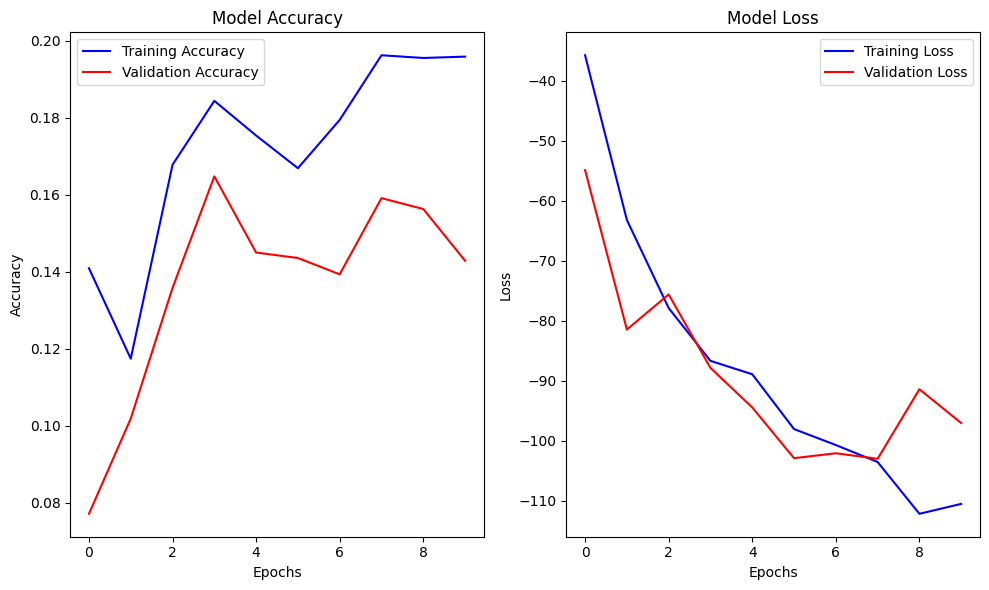

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have a 'history' object containing training/validation accuracy and loss
plt.figure(figsize=(10, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='b')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='r')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='b')
plt.plot(history.history['val_loss'], label='Validation Loss', color='r')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Reconstruct the testing data

reconstructed_datat = vae.predict(X_train)

# Calculate the reconstruction loss for each sample
reconstruction_losst = np.mean(np.square(X_train - reconstructed_datat), axis=1)

# Set a threshold to identify outliers
threshold = np.percentile(reconstruction_losst,50)  # Adjust the percentile as needed

# Identify the outliers
outlier_indicest= np.where(reconstruction_losst < threshold)[0]

outlier_datat = X_train[outlier_indicest]
#outlier_featuresname1 =np.array(outlier_data)[outlier_indicest[1]]

#print(outlier_datat)
print(outlier_indicest)
#print(outlier_featuresname1)
"""
def convert_data(data_list,outlier_indicest):
    result = []
    indexx=0
    for index, value in enumerate(data_list):
        if (outlier_indicest[indexx]== index):
            result.append(1)
            data_list[index]=1  # If index is even, add 0
            indexx=indexx+1
        else:
            result.append(0)  # If index is odd, keep the original value
            data_list[index]=0
    return data_list

# Example usage:

converted_data = convert_data(X_train,outlier_indicest)
#print(f"Original data: {X_train}")
print(f"Converted data: {converted_data}")
print(converted_data.shape)"""
print(outlier_datat.shape)
print(X_train)

221/221 [==============================] - 0s 2ms/step
[   3    4    5 ... 7058 7060 7065]
(3535, 61)
[[ 1.472       3.224      -0.568      ...  0.976      -0.288
  -0.072     ]
 [-0.85897436  1.67948718  1.32051282 ...  5.69230769 -0.03846154
   0.25641026]
 [-0.07665505  3.81184669 -0.21254355 ...  0.40766551  0.68641115
  -0.15679443]
 ...
 [-0.92519685 -5.33858268  0.07086614 ... -1.65748031  0.19685039
   0.24409449]
 [-0.64583333 -7.28125     1.58333333 ... -3.1875      0.5
   0.01041667]
 [-0.80508475 -6.98728814  0.11440678 ... -2.76271186  0.13559322
  -0.01271186]]


In [ ]:
print(outlier_datat.shape)
print(X_train)

(61, 3535)
[[ 1.472       3.224      -0.568      ...  0.976      -0.288
  -0.072     ]
 [-0.85897436  1.67948718  1.32051282 ...  5.69230769 -0.03846154
   0.25641026]
 [-0.07665505  3.81184669 -0.21254355 ...  0.40766551  0.68641115
  -0.15679443]
 ...
 [-0.92519685 -5.33858268  0.07086614 ... -1.65748031  0.19685039
   0.24409449]
 [-0.64583333 -7.28125     1.58333333 ... -3.1875      0.5
   0.01041667]
 [-0.80508475 -6.98728814  0.11440678 ... -2.76271186  0.13559322
  -0.01271186]]


In [ ]:
X_test_t = X_test.T

print(X_test_t.shape[1])
print(X_test.shape)

151
(151, 7070)


In [ ]:
Rowadd=len(X_train[0])-len(X_test[0])
print(Rowadd)
print(X_test_t.shape[1])
print(X_test_t.shape)
print(X_test.shape)
#print(df2)


-7009
7070
(196, 7070)
(151, 7070)


In [ ]:


df2 = pd.DataFrame([[0]*X_test_t.shape[1]]*Rowadd)

X_test_t = np.concatenate([X_test_t,df2])
print(df2.shape)
print(X_test_t.shape)

print(X_train.shape,X_test.shape,X_test_t.shape)





ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 7070 and the array at index 1 has size 196

In [ ]:
y_test_t=y_test.T
df2 = pd.DataFrame([[0]*y_test_t.shape[0]]*Rowadd)
A=np.array([0]*y_test_t.shape[0]*Rowadd)

y_test_t = np.concatenate([y_test,A])
print(A.shape)
print(y_test_t.shape)
print(y_test.shape)





(720,)
(736,)
(16,)


In [ ]:
y_test2=y_test_t
print(y_test2.shape)

(736,)


In [ ]:
X_test = X_test_t.T

print(X_test_t.shape[1])
print(X_test.shape[1])

7070
151


In [ ]:
# Reconstruct the testing data

reconstructed_data = vae.predict(X_test)

# Calculate the reconstruction loss for each sample
reconstruction_loss = np.mean(np.square(X_test - reconstructed_data), axis=1)

# Set a threshold to identify outliers
threshold = np.percentile(reconstruction_loss,50)  # Adjust the percentile as needed

# Identify the outliers
outlier_indices = np.where(reconstruction_loss < threshold)[0]
outlier_data = X_test[outlier_indices]

#outlier_featuresname1 =np.array(outlier_data)[outlier_indices[1]]
#outlier_features1 =selected_featuresindex[outlier_indices[1]]
print(outlier_indices)
"""

def convert_data(data_list2,outlier_indices):
    result = []
    indexx=0
    for index, value in enumerate(data_list2):
        if (outlier_indices[indexx]== index):
            result.append(1)
            data_list2[index]=1  # If index is even, add 0
            indexx=indexx+1
        else:
            result.append(0)  # If index is odd, keep the original value
            data_list2[index]=0
    return data_list2

# Example usage:

converted_data2 = convert_data(X_test,outlier_indicest)
#print(f"Original data: {X_train}")
print(f"Converted data: {converted_data2}")
print(converted_data2.shape)"""
print(outlier_data.shape)
print(X_test)

InvalidArgumentError: Graph execution error:

Detected at node vae/encoder/dense_7/Relu defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-73-f31b98e3e910>", line 3, in <cell line: 3>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2655, in predict

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py", line 255, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/activations.py", line 306, in relu

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5395, in relu

Matrix size-incompatible: In[0]: [32,151], In[1]: [61,64]
	 [[{{node vae/encoder/dense_7/Relu}}]] [Op:__inference_predict_function_75197]

#genetic

In [ ]:
pip install sklearn-genetic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from genetic_selection import GeneticSelectionCV
from sklearn import datasets, linear_model
from sklearn import svm

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score


In [ ]:
outlier_datat_t = outlier_datat.T
#outlier_data_t = outlier_data.T

print (outlier_datat_t .shape)
#print (outlier_data_t .shape)


(61, 3535)


In [ ]:

X_train=X_train.T
X_test=X_test.T
print (X_train .shape)
print (X_test .shape)

(61, 7070)
(151, 7070)


In [ ]:
estimator = linear_model.LogisticRegression(solver="liblinear",random_state=0)
#estimator =svm.SVC(kernel='linear')


selector = GeneticSelectionCV(
        estimator,
        cv=5,
        verbose=1,
        scoring="accuracy",
        max_features=300,
        n_population=30,
        crossover_proba=0.5,
        mutation_proba=0.2,
        n_generations=50,
        crossover_independent_proba=0.5,
        mutation_independent_proba=0.1,

        n_gen_no_change=None,
        caching=False,
        n_jobs=1
    )




# New Section mean all runs

#genetic 10 run

In [ ]:
import random
random.seed(42)
num_executions = 5  # تعداد اجراها
results = []  # لیست نتایج اجراها
summ=0
for i in range(num_executions):
    random.seed(42)
    out = selector.fit(X_train, y_train)
    print("runnnnnnnnnnnnnn",i)
    selected_featuresindex = out.get_support(indices=True)
    print(out.support_)
    result = selected_featuresindex  # اجرای الگوریتم ژنتیک
    summ+=len(selected_featuresindex)
    results.append(result)  # ذخیره نتیجه در لیست
    print(results)

# محاسبه میانگین
mean_result = summ / num_executions

# یافتن ویژگی‌های مشترک
common_features = set(results[0])  # فرض بر گرفتن ویژگی‌های اولیه

for resultt in results:

    common_features = common_features.intersection(set(resultt))
    #common_features =common_features & set(results[result])





print("Mean Result:", mean_result)
print("Common Features:", common_features)

Selecting features with genetic algorithm.
gen	nevals	avg                                  	std                               	min                            	max                                  
0  	30    	[   0.852265  148.033333    0.071278]	[  0.062859  88.873499   0.023716]	[ 0.623077  1.        0.028205]	[   0.951282  288.          0.110286]
1  	16    	[-1332.558761   288.        1333.392086]	[ 3399.650155   241.99697   3399.323298]	[-10000.           10.            0.002564]	[     0.951282    948.        10000.      ]
2  	16    	[-1999.272564   349.966667  2000.049304]	[ 4000.363718   278.07343   3999.975348]	[-10000.          118.            0.002564]	[     0.966667    947.        10000.      ]
3  	19    	[-2999.352265   389.766667  3000.03526 ]	[ 4582.999737   316.035724  4582.552612]	[-10000.          118.            0.002564]	[     0.983333    937.        10000.      ]
4  	21    	[-2999.341453   352.766667  3000.036094]	[ 4583.006815   286.007888  4582.552066]	[-10000.     

In [ ]:
d=len(results)
print(len(results[0]),len(results[1]),len(results[2]),len(results[3]),len(results[4]))



144 139 129 206 244


# name of featurese selected

In [ ]:
selected_featuresindex = selector.get_support(indices=True)
print(len(selected_featuresindex))

In [ ]:
selected_features = [X_train_m.columns[i] for i, selected in enumerate(selector.support_) if selected]
print(selected_features)
print(len(selected_features))

# 3Run  plot on logestic

In [ ]:
pip install scikit-plot

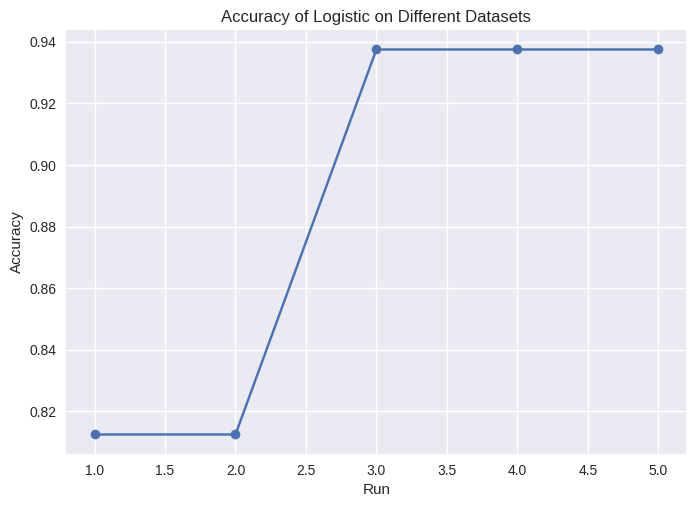

Mean Accuracy: 0.94


<ipython-input-121-8f58d52e0d3d>:85: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


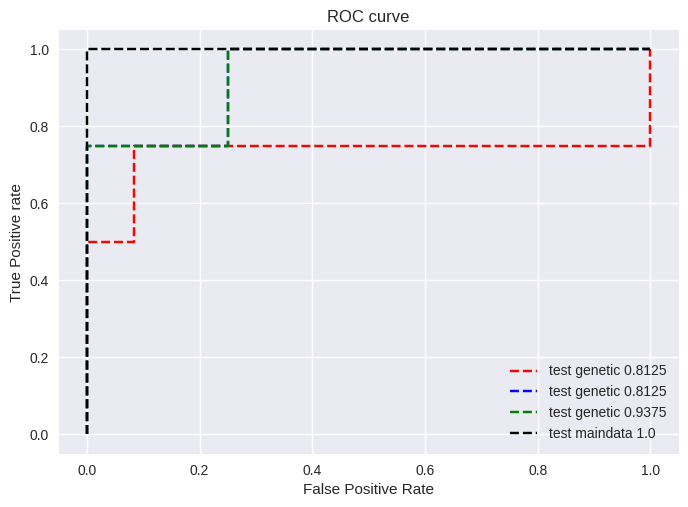

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import accuracy_score
import scikitplot as skplt
d=len(results)

    #X_train_ge=X_train_ge.T


# Create an empty list to store accuracy scores
accuracy_scores = []
probas_list=[]
y_predic=[]
aucc=[]
fpr1=[]
tpr1=[]
# Run SVM on each dataset and calculate accuracy
#for r in results:

  #  X_train_ge=X_train[r]
  #  X_train_ge=X_train_ge.T
    #ytrain = y_train[:,1]

 #   X_test_ge=X_test[r]
 #   X_test_ge=X_test_ge.T
for r in range(d):
    X_train_ge=X_train_m[:,results[r]]
    X_test_ge=X_test_m[:,results[r]]
    #ytest = y_test2[:,1]

     # Create an SVM classifier
    #clf = svm.SVC(probability=True)
    #clf= LogisticRegression()
    clf=linear_model.LogisticRegression(solver="liblinear",random_state=0)

    # Fit the classifier to the data
    clf.fit(X_train_ge, y_train)
    # Make predictions on the same dataset
    y_predp = clf.predict_proba(X_test_ge)
    y_pred = clf.predict(X_test_ge)
    # Calculate accuracy and append to the list
    probas_list.append(y_predp)
    accuracy = accuracy_score(y_test, y_pred)
    y_predic.append(y_pred)
    accuracy_scores.append(accuracy)
    y_pred_proba = clf.predict_proba(X_test_ge)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    fpr1.append(fpr)
    tpr1.append(tpr)
    aucc.append(auc)
    #plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    #plt.legend(loc=4)
    #plt.show()

clf=linear_model.LogisticRegression(solver="liblinear",random_state=0)
clf.fit(X_train_m, y_train)
y_pred = clf.predict(X_test_m)
accuracy1 = accuracy_score(y_test, y_pred)
y_pred_proba = clf.predict_proba(X_test_m)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,y_pred_proba)

fpr1.append(fpr)
tpr1.append(tpr)
# Plot the accuracy for each run
plt.plot(range(1,6), accuracy_scores, marker='o')
plt.xlabel('Run')
plt.ylabel('Accuracy')
plt.title('Accuracy of Logistic on Different Datasets')
plt.show()


#plt.plot(fpr,tpr,label="data 1, auc="+str(aucc))
#plt.legend(loc=4)
#plt.show()

# Calculate and display the mean accuracy across runs
mean_accuracy = np.max(accuracy_scores)
print("Mean Accuracy: {:.2f}".format(mean_accuracy))


# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1[0], tpr1[0], linestyle='--',color='red', label= 'test genetic '+str(accuracy_scores[0]))
plt.plot(fpr1[1], tpr1[1], linestyle='--',color='blue', label='test genetic '+str(accuracy_scores[1]))
plt.plot(fpr1[2], tpr1[2], linestyle='--',color='green', label='test genetic '+str(accuracy_scores[2]))

plt.plot(fpr1[5], tpr1[5], linestyle='--',color='black', label='test maindata '+str(accuracy1))
#plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
#plt.savefig('ROC',dpi=300)
plt.show();
#image = plt.figure(figsize=(16,10), dpi= 200)
#image.savefig('myimage.png',  bbox_inches="tight")
#files.download('myimage.png')

In [ ]:
print(accuracy_scores)

[0.8125, 0.8125, 0.9375, 0.9375, 0.9375]


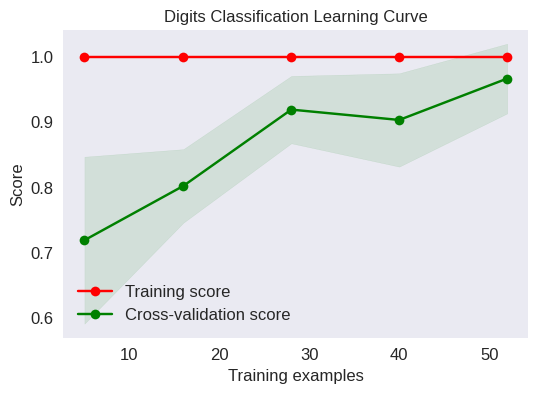

In [ ]:
skplt.estimators.plot_learning_curve(LogisticRegression(), X_train_ge, y_train,
                                     cv=7, shuffle=True, scoring="accuracy",
                                     n_jobs=-1, figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="Digits Classification Learning Curve");

In [ ]:
X_train_ge=X_train_m[:,results[0]]
X_test_ge=X_test_m[:,results[0]]

# test in felan anjam midam taki

# classification compare

In [ ]:
 clff=linear_model.LogisticRegression(solver="liblinear",random_state=0).fit(X_train_m, y_train)

In [ ]:
 #clff1=linear_model.LogisticRegression(solver="liblinear",random_state=0).fit(outlier_datat_t, y_train.iloc[:,1])


In [ ]:
 clff2=linear_model.LogisticRegression(solver="liblinear",random_state=0).fit(X_train_m[:,results[3]], y_train)


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_train, clff.predict(X_train_m)))

#print(classification_report(y_train.iloc[:,1], clff1.predict(outlier_datat_t)))




print(classification_report(y_train, clff2.predict(X_train_m[:,results[3]])))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        46
           1       1.00      1.00      1.00        15

    accuracy                           1.00        61
   macro avg       1.00      1.00      1.00        61
weighted avg       1.00      1.00      1.00        61

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        46
           1       1.00      1.00      1.00        15

    accuracy                           1.00        61
   macro avg       1.00      1.00      1.00        61
weighted avg       1.00      1.00      1.00        61



In [ ]:
X_test_m[:,results[3]]

array([[ 0.20887728, -0.23916811,  0.08161737, ...,  0.0154321 ,
         0.63655988, -0.02910798],
       [-0.91906005, -0.2322357 ,  0.15649569, ...,  0.42283951,
        -0.79699508, -0.1943662 ],
       [-0.53263708,  1.35181976,  0.81542493, ..., -0.14506173,
         0.07184181,  1.36995305],
       ...,
       [ 4.7310705 ,  2.56152513,  1.10595283, ..., -6.86728395,
         1.08263535,  1.16338028],
       [-1.1383812 ,  0.78682842,  1.3260951 , ...,  0.36111111,
        -0.33831275,  3.73239437],
       [-0.845953  ,  1.31715771,  0.24934481, ...,  0.44753086,
        -0.27320611,  4.62629108]])

In [ ]:
from sklearn.metrics import classification_report
#save resualt in file
with open("outputgenetic2.txt", "a") as f:
  print ("------------------------test logestic--------------------", file=f)
  print(classification_report(y_test_m, clff.predict(X_test_m)), file=f)

  print ("------------------------test feature select genetic  logestic--------------------", file=f)
  print(classification_report(y_test_m, clff2.predict(X_test_m[:,results[3]])), file=f)




In [ ]:

from sklearn import metrics
y_pred = clff2.predict(X_test_m[:,results[3]])
cnf_matrix = metrics.confusion_matrix(y_test_m, y_pred)

print("Accuracy:",metrics.accuracy_score(y_test_m,y_pred))
print(cnf_matrix)

Accuracy: 0.9375
[[11  1]
 [ 0  4]]


#confusion mat

<ipython-input-178-cd27408b206e>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-178-cd27408b206e>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


Accuracy: 0.9375


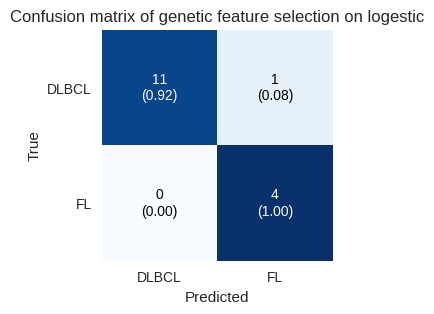

<ipython-input-178-cd27408b206e>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-178-cd27408b206e>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


Accuracy: 1.0


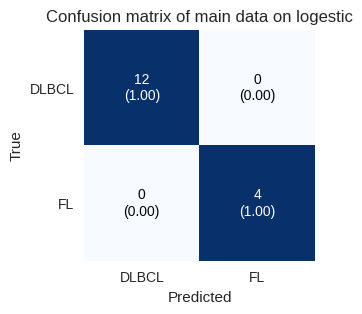

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

labels = ['DLBCL', 'FL']
y_pred = clff2.predict(X_test_m[:,results[3]])
cnf_matrix = metrics.confusion_matrix(y_test_m, y_pred)

fig, ax = plot_confusion_matrix(conf_mat=cnf_matrix,figsize=(3, 3),show_absolute=True,show_normed=True)
plt.title('Confusion matrix of genetic feature selection on logestic')
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
print("Accuracy:",metrics.accuracy_score(y_test_m,y_pred))
plt.show()


cm = confusion_matrix(y_test_m, clff.predict(X_test_m))
fig, ax = plot_confusion_matrix(conf_mat=cm,figsize=(3, 3),show_absolute=True,show_normed=True)
plt.title('Confusion matrix of main data on logestic')
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
print("Accuracy:",metrics.accuracy_score(y_test_m, clff.predict(X_test_m)))
plt.show()

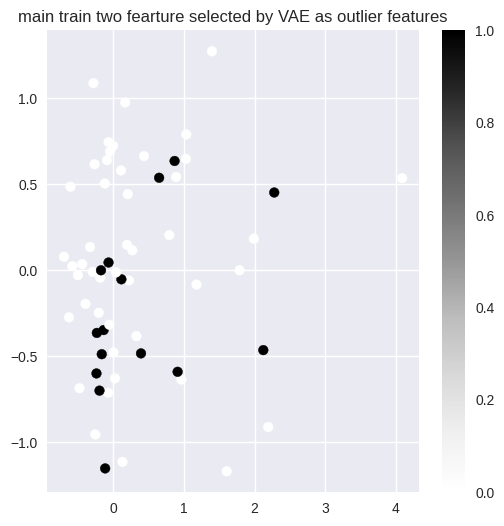

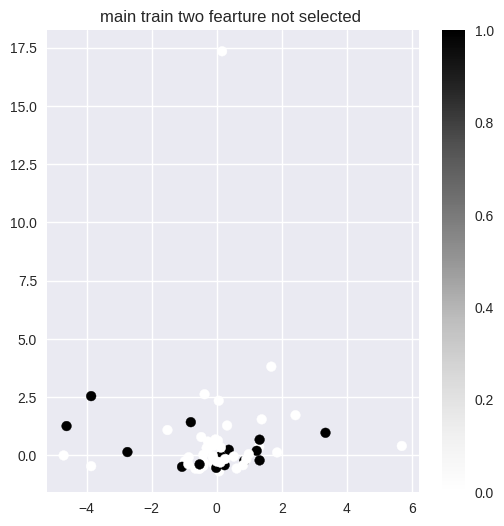

In [ ]:
plt.figure(figsize=(6, 6))
plt.title('main train two fearture selected by VAE as outlier features')
plt.scatter(outlier_datat_t[:, 0],outlier_datat_t[:, 1], c=y_train_m)

plt.colorbar()
plt.show()
plt.figure(figsize=(6, 6))
plt.title('main train two fearture not selected ')
plt.scatter(X_train_m[:, 1],X_train_m[:, 2], c=y_train_m)

plt.colorbar()
plt.show()



In [ ]:

outlier_datat=outlier_datat.T
print(outlier_datat.shape,X_train_m.shape)

(61, 3535) (61, 7070)


3
4
[-0.63101604  2.19251337 -0.11764706 -0.44385027  1.78609626 -0.13903743
  4.09090909  2.27807487  0.43315508  0.96256684  0.21925134 -0.3315508
  0.          1.17647059 -0.23529412  0.19251337 -0.29411765  0.10695187
  0.79144385  0.1657754   0.02139037 -0.60962567 -0.5026738  -0.05882353
  0.11229947 -0.00534759 -0.07486631  2.12299465 -0.70053476 -0.5828877
 -0.25668449 -0.18716578 -0.09090909  0.12834225 -0.19786096 -0.28342246
 -0.39572193  0.26737968  0.64705882 -0.06951872 -0.1657754  -0.17647059
  0.20320856  0.86631016  1.60427807  0.03743316  0.90909091 -0.48128342
  0.39037433 -0.06951872  1.03208556 -0.26737968  0.88770053  0.32620321
  1.02673797 -0.20855615 -0.24064171  1.98930481  1.39572193 -0.04812834
 -0.12299465]
out [-0.63101604  2.19251337 -0.11764706 -0.44385027  1.78609626 -0.13903743
  4.09090909  2.27807487  0.43315508  0.96256684  0.21925134 -0.3315508
  0.          1.17647059 -0.23529412  0.19251337 -0.29411765  0.10695187
  0.79144385  0.1657754   0.0213

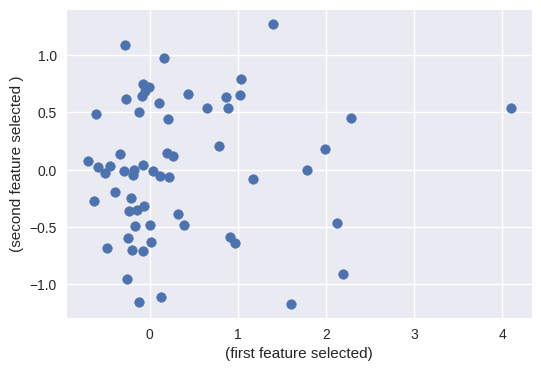

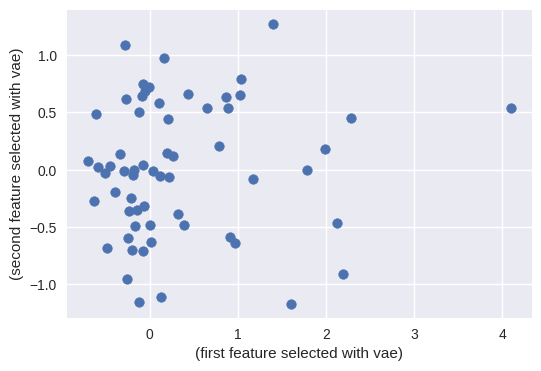

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
first=outlier_indicest[0]
second=outlier_indicest[1]

print(first)
print(second)
print (X_train_m[:,3])
print ("out",outlier_datat[:,0])
print(outlier_datat.shape,X_train_m.shape)
#b = np.where(outlier_datat[:,:]==X_train[:,first])
#print(b)

fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(X_train_m[:,first], X_train_m[:,second])
ax.set_xlabel('(first feature selected)')
ax.set_ylabel('(second feature selected )')
plt.show()
#df_train.columns[0]


# Scatter plot without outliers
fig, ax_no_outliers = plt.subplots(figsize=(6, 4))
ax_no_outliers.scatter(outlier_datat[:,0], outlier_datat[:,1])
ax_no_outliers.set_xlabel('(first feature selected with vae)')
ax_no_outliers.set_ylabel('(second feature selected with vae)')
plt.show()



In [ ]:
print(X_train.shape)
X_train=X_train.T
print(X_train.shape)

(61, 7070)
(7070, 61)


[t-SNE] Computing 60 nearest neighbors...
[t-SNE] Indexed 61 samples in 0.001s...
[t-SNE] Computed neighbors for 61 samples in 0.056s...
[t-SNE] Computed conditional probabilities for sample 61 / 61
[t-SNE] Mean sigma: 45.250698
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.364540
[t-SNE] KL divergence after 800 iterations: 0.147876


[Text(0.5, 1.0, 'main train data T-SNE projection')]

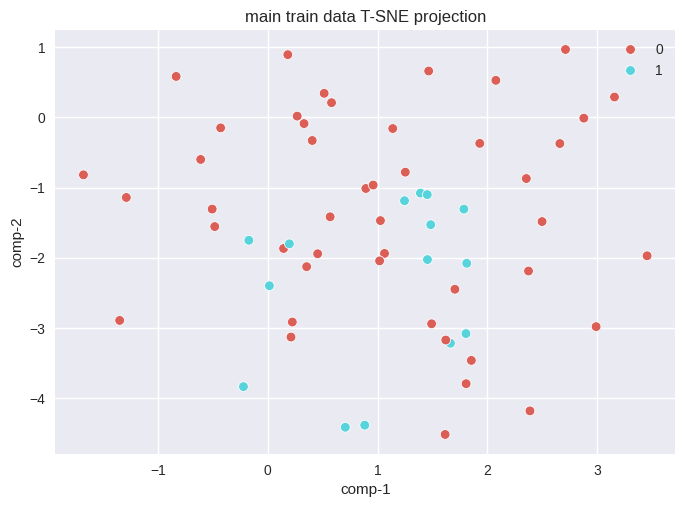

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(X_train_m)
df = pd.DataFrame()
df["y"] = y_train_m
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 2),
                data=df).set(title="main train data T-SNE projection")

In [ ]:
print(outlier_datat.shape)
outlier_datat=outlier_datat.T
print(outlier_datat.shape)

(38, 3564)
(3564, 38)
